In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

import smfret.evaluation as evaluation

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.multi_task_learning import SavedTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics

from sciplotlib import style as spstyle

In [7]:
def load_kinsoft_synthetic_trace(path, trace_id, training=True):
    """Loads txt trace files and labels."""
    trace_txt = os.path.join(path, f'trace_{trace_id}.txt')
    label_txt = os.path.join(path, f'state_time_{trace_id}.txt')
    data = np.loadtxt(trace_txt, comments='%')
    
    structured_data = {
        'time': data[:, 0],
        'donor': data[:, 1],
        'acceptor': data[:, 2],
    }
    
    if training:
        label = np.loadtxt(label_txt, comments='%')
        time = data[:, 0]
        state_label = np.zeros_like(time)
        for state, degenerate_state, start, dwell in label:
            state_label[time >= start] = state
        structured_data['label'] = state_label - 1
    else:
        structured_data['label'] = np.zeros_like(data[:, 0])
    
    return structured_data

In [ ]:
def kinsoft_trace_to_tensor(trace):
    """Properly converts a kinsoft trace into a tensor."""
    min_unit_length = 100
    trace_set = FRETTraceSet()
    for attr in trace:
        setattr(trace_set, attr, np.expand_dims(trace[attr], axis=0))
    trace_set.time = np.arange(1, trace_set.donor.shape[1] + 1)
    trace_set.size = 1
    trace_set.is_labeled = True
    trace_set.trim(len(trace_set.time) // min_unit_length * min_unit_length)
    return trace_set

In [22]:
test_sets = []
truncate_length_window = 4000
min_length_unit = 100
for i in range(1, 500):
    try:
        trace = load_kinsoft_synthetic_trace('saved_dataset/Traces_EG_10ms/', i, training=False)
    except:
        continue

    truncate_number = len(trace['time']) // truncate_length_window
    for j in range(truncate_number):
        trace = load_kinsoft_synthetic_trace('saved_dataset/Traces_EG_10ms/', i, training=False)
        test_set = kinsoft_trace_to_tensor(trace)
        test_set.trim(truncate_length_window, start_frame=(j * truncate_length_window))
        test_set.trim(len(test_set.time) // min_length_unit * min_length_unit)
        test_sets.append(test_set)

In [16]:
def get_fret_value(trace, states, target_state):
    """Calcualtes the mean FRET value."""
    return list(trace.fret[states == target_state])

In [14]:
def use_posterior(prob, max_marginal_prob=0.05):
    marginal_prob = np.mean(prob, axis=-2)
    marginal_prob[marginal_prob >= max_marginal_prob] = max_marginal_prob
    post_prob = np.einsum('itk,ik->itk', prob, marginal_prob)
    return post_prob

In [20]:
def reject_outliers(data, m = 2.):
    """Reject outliner datapoints."""
    data = np.array(data)
    d = np.abs(data - np.mean(data))
    mean = np.median(d)
    s = d / mean if mean else np.zeros(len(d))
    return data[s<m]

In [15]:
# linetime measurement

def lifetime(label):
    """Finds the lifetime according to the labeled states."""
    l = 0
    label = np.array(label)
    for i in range(len(label) - 1, 0, -1):
        if label[i] > 0:
            return i
    return 0

In [53]:
model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})

In [54]:
print(len(test_sets), 'truncated traces generated from experimental data.')

repeats = 1
k_zero_one_list = []
k_one_zero_list = []
FRET_zero_list = []
FRET_one_list = []
for repeat in range(repeats):
    tau_one = []
    tau_zero = []
    FRET_zero = []
    FRET_one = []
    keras.utils.set_random_seed(140 + repeat)
    # segmenter = finetuning.finetune_classification_head(encoder=ours_framewise, train_sets=trace_sets, epochs=500, lr=1e-2, trace_level=False, use_sklearn=True)
    for test_set in test_sets:
        # pred_state = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1)[0, ...]
        # pred_state = np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1).numpy()[0,...,1], np.ones(5) / 5, 'same') > 0.5
        ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor(), verbose=0), axis=-1)), axis=-1), tf.float32)
        pred_state = ideal_fret[0, :].numpy() // 2
        low_fret_state = np.quantile(pred_state[pred_state>0], 0.1)
        high_fret_state = np.quantile(pred_state[pred_state>0], 0.9)
        tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
        tau_one += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
        FRET_zero += get_fret_value(test_set.traces[0], pred_state, target_state=low_fret_state)
        FRET_one += get_fret_value(test_set.traces[0], pred_state, target_state=high_fret_state)
    
    bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 500)
    # bins = np.linspace(0, 250, 50)
    time_resolution = 0.01
    k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one_list.append(k_zero_one)
    k_one_zero_list.append(k_one_zero)
    FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=5)))
    FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=5)))
    print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

47 truncated traces generated from experimental data.
k_{12} = 2.9345900121509323 k_{21} = 3.417332655235786 FRET_1 = 0.2682677293002658 FRET_2 = 0.7125281920630797


In [44]:
benchmarks = pd.read_csv('../challenge_data/Source Data/Figure2/figure2_expt_summary.csv').to_dict(orient='index')

In [49]:
print('k_{12}=', np.mean([benchmarks[idx]['k12'] for idx in range(len(benchmarks))]))
print('+/-k_{12}=', np.std([benchmarks[idx]['k12'] for idx in range(len(benchmarks))]))

k_{12}= 2.8173635714285714
+/-k_{12}= 0.31885718723518


In [52]:
benchmarks

{0: {'Method': 'Pomegranate',
  'FRET E 1': 0.268,
  'std E1': 0.07,
  'FRET E 2': 0.711,
  'std E2': 0.083,
  'k12': 2.91,
  'k12 + delta': 0.1,
  'k12 - delta': 0.1,
  'k21': 3.19,
  'k21 + delta': 0.1,
  'k21 - delta': 0.1},
 1: {'Method': 'Tracy (HMM)',
  'FRET E 1': 0.27,
  'std E1': 0.07,
  'FRET E 2': 0.72,
  'std E2': 0.08,
  'k12': 2.5,
  'k12 + delta': 0.1,
  'k12 - delta': 0.1,
  'k21': 3.0,
  'k21 + delta': 0.1,
  'k21 - delta': 0.1},
 2: {'Method': 'FRETboard',
  'FRET E 1': 0.268,
  'std E1': 0.0714,
  'FRET E 2': 0.7,
  'std E2': 0.106,
  'k12': 2.71,
  'k12 + delta': 0.321,
  'k12 - delta': 0.32,
  'k21': 3.11,
  'k21 + delta': 0.503,
  'k21 - delta': 0.532},
 3: {'Method': 'Hidden-Markury',
  'FRET E 1': 0.268,
  'std E1': 0.07,
  'FRET E 2': 0.711,
  'std E2': 0.083,
  'k12': 3.17,
  'k12 + delta': 0.31,
  'k12 - delta': 0.31,
  'k21': 2.65,
  'k21 + delta': 0.2,
  'k21 - delta': 0.2},
 4: {'Method': 'SMACKS(SS)',
  'FRET E 1': 0.26,
  'std E1': 0.0,
  'FRET E 2': 0.7

In [48]:
print('k_{21}=', np.mean([benchmarks[idx]['k21'] for idx in range(len(benchmarks))]))
print('+/-k_{21}=', np.std([benchmarks[idx]['k21'] for idx in range(len(benchmarks))]))

k_{21}= 3.032281428571428
+/-k_{21}= 0.4696747664053917


In [50]:
print('E_1=', np.mean([benchmarks[idx]['FRET E 1'] for idx in range(len(benchmarks))]))
print('+/-E_1=', np.std([benchmarks[idx]['FRET E 1'] for idx in range(len(benchmarks))]))

E_1= 0.26608218264285716
+/-E_1= 0.004083685927786595


In [51]:
print('E_2=', np.mean([benchmarks[idx]['FRET E 2'] for idx in range(len(benchmarks))]))
print('+/-E_2=', np.std([benchmarks[idx]['FRET E 2'] for idx in range(len(benchmarks))]))

E_2= 0.7108806699999999
+/-E_2= 0.004525071334084937


<Figure size 1500x200 with 0 Axes>

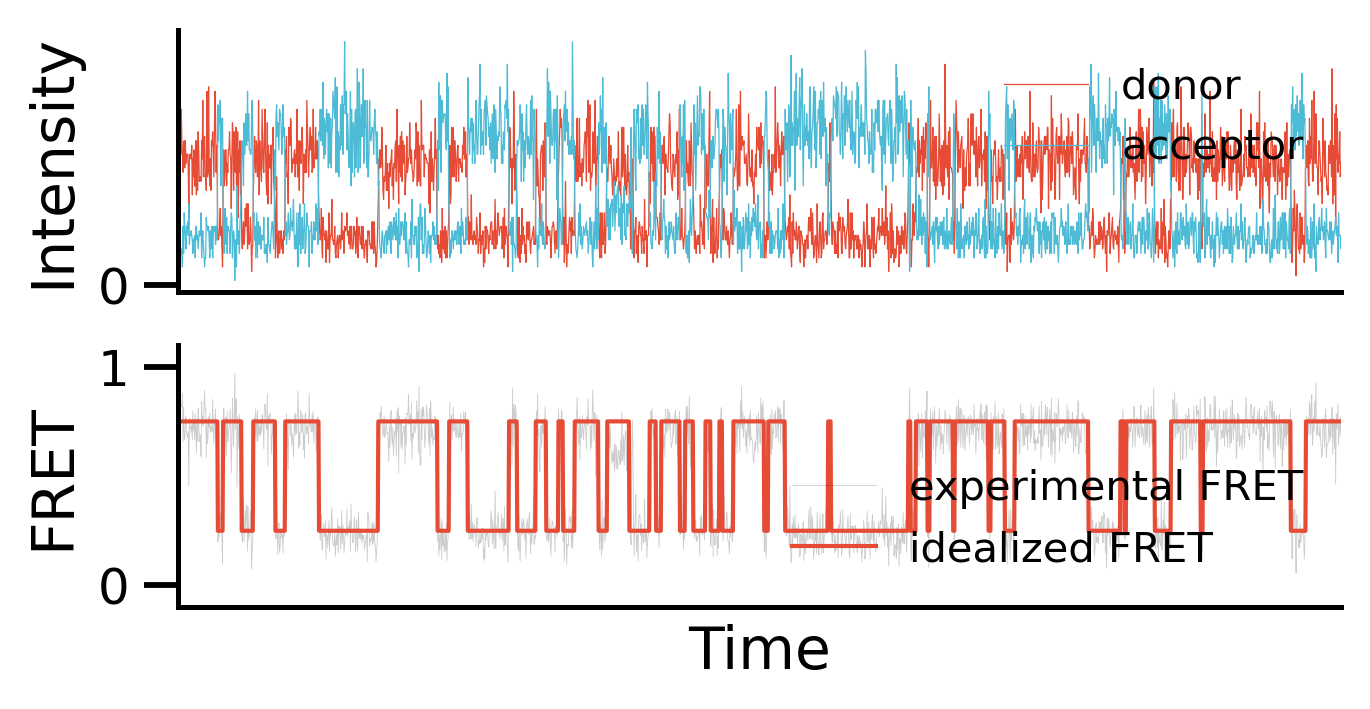

In [41]:
idx = 30
plt.figure(figsize=(15, 2))
# test_sets[idx].label = np.expand_dims(np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_sets[idx]), axis=-1).numpy()[0,...,-1], np.ones(3) / 3, 'same'), 0) > 0.5
test_sets[idx].label =  FRETStateTraceSet.fret_states_resolution * np.array(tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_sets[idx].to_tensor(), verbose=0), axis=-1)), axis=-1), tf.float32))
# test_sets[idx].plot_traces(n_traces=1)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    ax=axes[0]
    ax.plot(test_sets[idx].traces[0].acceptor , linewidth=0.3, label='donor')
    ax.plot(test_sets[idx].traces[0].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 2000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(test_sets[idx].traces[0].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(test_sets[idx].label[0, :], linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 2000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    # color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # plt.figure(figsize=(8, 1.5))
    # color[0], color[1] = '#559AD1', '#DF6767'
    # plt.plot(test_sets[idx].traces[0].fret, linewidth=1, color='black', alpha=0.5)
    # plt.plot(test_sets[idx].label[0, :], linewidth=1, color=color[1])
    # plt.xlim([-10, 600])
    plt.savefig('figures/kinsoft-idealization-trace.svg', transparent=True, dpi=120)

In [49]:
ref_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_2STATE.npz', size=2000)

In [50]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_2STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)
true_lifetime = []
predicted_lifetime = []
correct_state_count = []
high_fret_error = []
low_fret_error = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 3)
    high_fret_error.append(np.max(ideal_fret[i, ...]) - np.max(ref_set.label[i, ...]))
    x, y = ideal_fret[i, ...], ref_set.label[i, ...]
    x, y = x[x>0], y[y>0]
    low_fret_error.append(np.min(x) - np.min(y))

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))
print('MAE High FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(high_fret_error)))
print('MAE Low FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(low_fret_error)))

63/63 [==============================] - 11s 122ms/step
MAE= 0.959
State Count Accuracy = 0.6825
MAE High FRET= 0.010225
MAE Low FRET= 0.00915


False


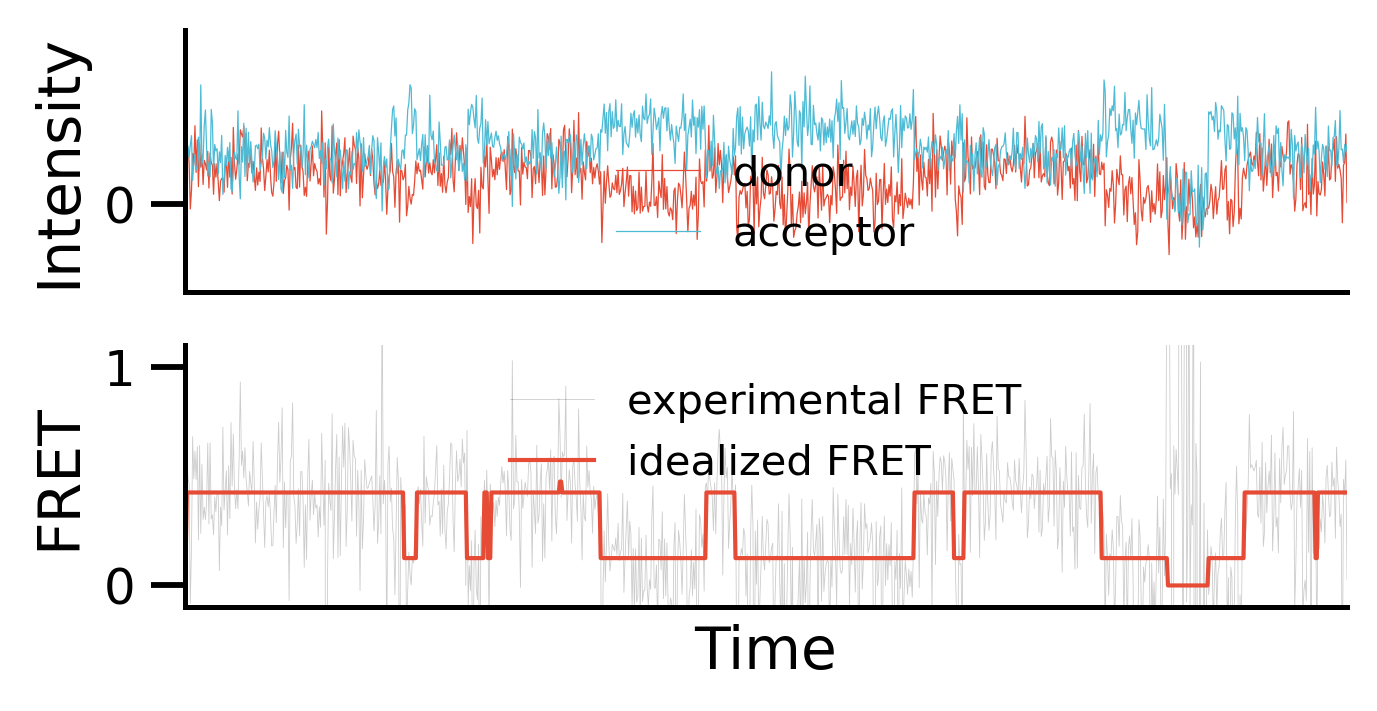

In [52]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    n = 5
    print(correct_state_count[n])
    ax=axes[0]
    ax.plot(ref_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(ref_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 1000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(ref_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] - 0.5, 0) * FRETStateTraceSet.fret_states_resolution, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 1000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    # plt.savefig('figures/trace_with_fret.svg', transparent=True)
    # plt.savefig('figures/trace_with_fret.png', transparent=True)

In [53]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

true_lifetime = []
predicted_lifetime = []
correct_state_count = []
high_fret_error = []
low_fret_error = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 3)
    high_fret_error.append(np.max(ideal_fret[i, ...]) - np.max(ref_set.label[i, ...]))
    x, y = ideal_fret[i, ...], ref_set.label[i, ...]
    x, y = x[x>0], y[y>0]
    low_fret_error.append(np.min(x) - np.min(y))

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))
print('MAE High FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(high_fret_error)))
print('MAE Low FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(low_fret_error)))

63/63 [==============================] - 10s 116ms/step
MAE= 0.9495
State Count Accuracy = 0.661
MAE High FRET= 0.010675
MAE Low FRET= 0.009500000000000001


In [ ]:
# Generate a dataset with:
# 1. K12 and K21
# 2. E1 and E2.



In [119]:
rng = np.random.default_rng()

def make_transition_prob_fn(k12, k21):
    counter = 0
    def transition_prob_fn():
        nonlocal counter
        counter += 1
        if counter % 2 == 0:
            return k12
        else:
            return k21
    return transition_prob_fn

def make_fret_value_fn(E1, E2):
    counter = 0
    def fret_value_fn():
        nonlocal counter
        counter += 1
        if counter % 2 == 0:
            return E2
        else:
            return E1
    return fret_value_fn

# uses default trace_length = 2000 
params_gen_base = ParameterGenerator(
    num_states_fn=lambda: 2,
    snr_signal_fn=lambda: rng.uniform(4, 12),
    snr_background_fn=lambda: rng.uniform(4, 12),
    transition_prob_fn=make_transition_prob_fn(0.06, 0.02),
    fret_states_fn=make_fret_value_fn(0.3, 0.7),
    donor_lifetime_fn=lambda: rng.uniform(low=1000, high=4000),
    trace_length_fn=lambda: 4000,
)

In [132]:
test_set = FRETStateTraceSet(size=1000, params_gen=params_gen_base)

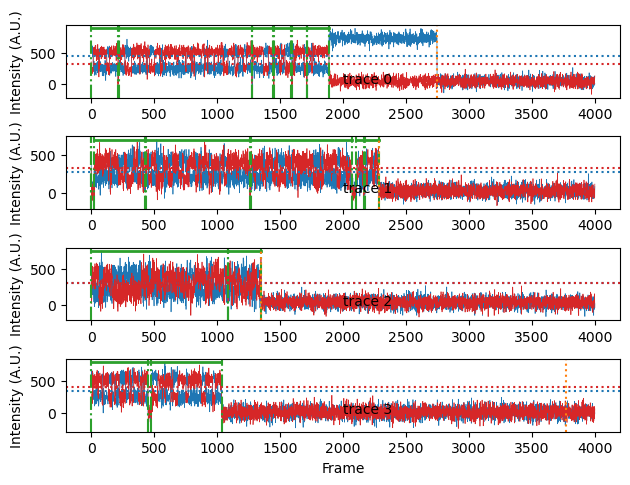

In [133]:
test_set.plot_traces(n_start=0, n_traces=4)

In [148]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_2STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

32/32 [==============================] - 8s 155ms/step


True


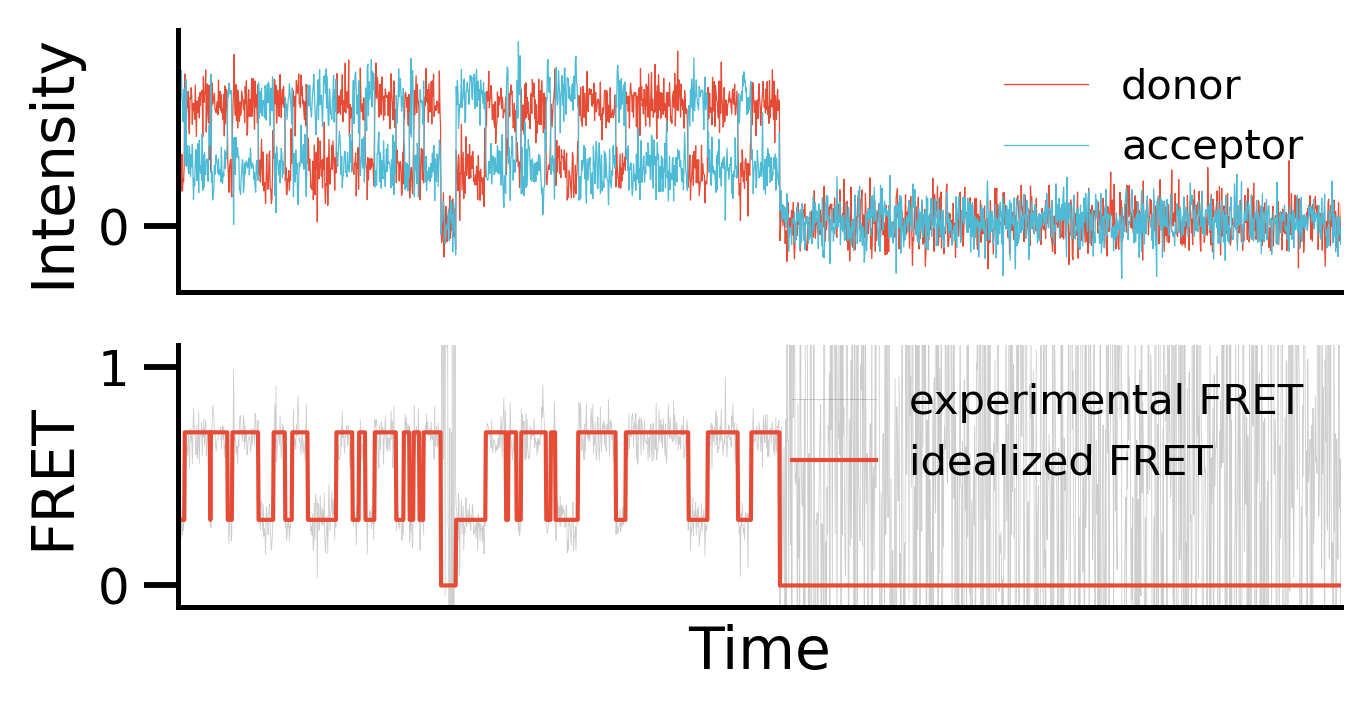

In [149]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    n = 3
    print(correct_state_count[n])
    ax=axes[0]
    ax.plot(test_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(test_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 2000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(test_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] // 2, 0) * FRETStateTraceSet.fret_states_resolution * 2, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 2000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_2_state_with_fret.svg', transparent=True)
    plt.savefig('figures/trace_2_state_with_fret.png', transparent=True)

In [150]:
def get_fret_value(trace, states, target_state):
    """Calcualtes the mean FRET value."""
    return list(trace.fret[states == target_state])

In [151]:
def reject_outliers(data, m = 2.):
    """Reject outliner datapoints."""
    data = np.array(data)
    d = np.abs(data - np.mean(data))
    mean = np.median(d)
    s = d / mean if mean else np.zeros(len(d))
    return data[s<m]

In [157]:
FRET_zero_list = []
FRET_one_list = []

tau_one = []
tau_zero = []
FRET_zero = []
FRET_one = []

for i in range(test_set.size):
    pred_state = ideal_fret[i, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.1)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.9)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(test_set.traces[i], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(test_set.traces[i], pred_state, target_state=high_fret_state)

bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 0.06096965395696953 k_{21} = 0.0200523229578301 
 FRET_1 = 0.3071316035690625 FRET_2 = 0.6859418083036477


In [162]:
(0.06096965395696953 - 0.06) / 0.06, (0.0200523229578301 - 0.02) / 0.02

(0.01616089928282554, 0.002616147891505022)

In [158]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

32/32 [==============================] - 8s 154ms/step


In [159]:
FRET_zero_list = []
FRET_one_list = []

tau_one = []
tau_zero = []
FRET_zero = []
FRET_one = []

for i in range(test_set.size):
    pred_state = ideal_fret[i, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.1)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.9)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(test_set.traces[i], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(test_set.traces[i], pred_state, target_state=high_fret_state)

bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 0.06133803737393534 k_{21} = 0.02014607318681152 
 FRET_1 = 0.3068675653091214 FRET_2 = 0.6859537352359092


In [163]:
(0.06133803737393534 - 0.06) / 0.06, (0.02014607318681152 - 0.02) / 0.02

(0.022300622898922356, 0.0073036593405760575)

In [215]:
np.quantile(test_set.fret.flat, 0.93)

1.2435887741533642

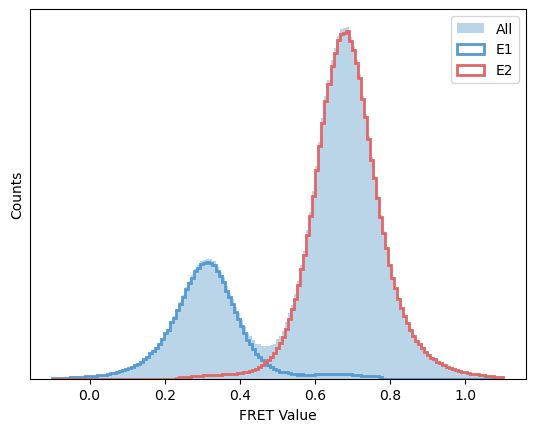

In [262]:
# with plt.style.context(spstyle.get_style('nature-reviews')):
fig, ax = plt.subplots(1, 1)
color[0], color[1] = '#559AD1', '#DF6767'
plt.hist(reject_outliers(np.concatenate([FRET_one, FRET_zero]), m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=0.3, edgecolor='none', label='All')

plt.hist(reject_outliers(FRET_zero, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1,histtype='step', linewidth=2, label='E1', color=color[0])
# plt.axvline(np.mean(reject_outliers(FRET_zero, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_one, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E2', color=color[1])
# plt.axvline(np.mean(reject_outliers(FRET_one, m=8)), linewidth=1, linestyle=':')
ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('FRET Value')
ax.legend()
plt.savefig('figures/fret_hist_2_state.svg', transparent=True)
plt.savefig('figures/fret_hist_2_state.png', transparent=True)

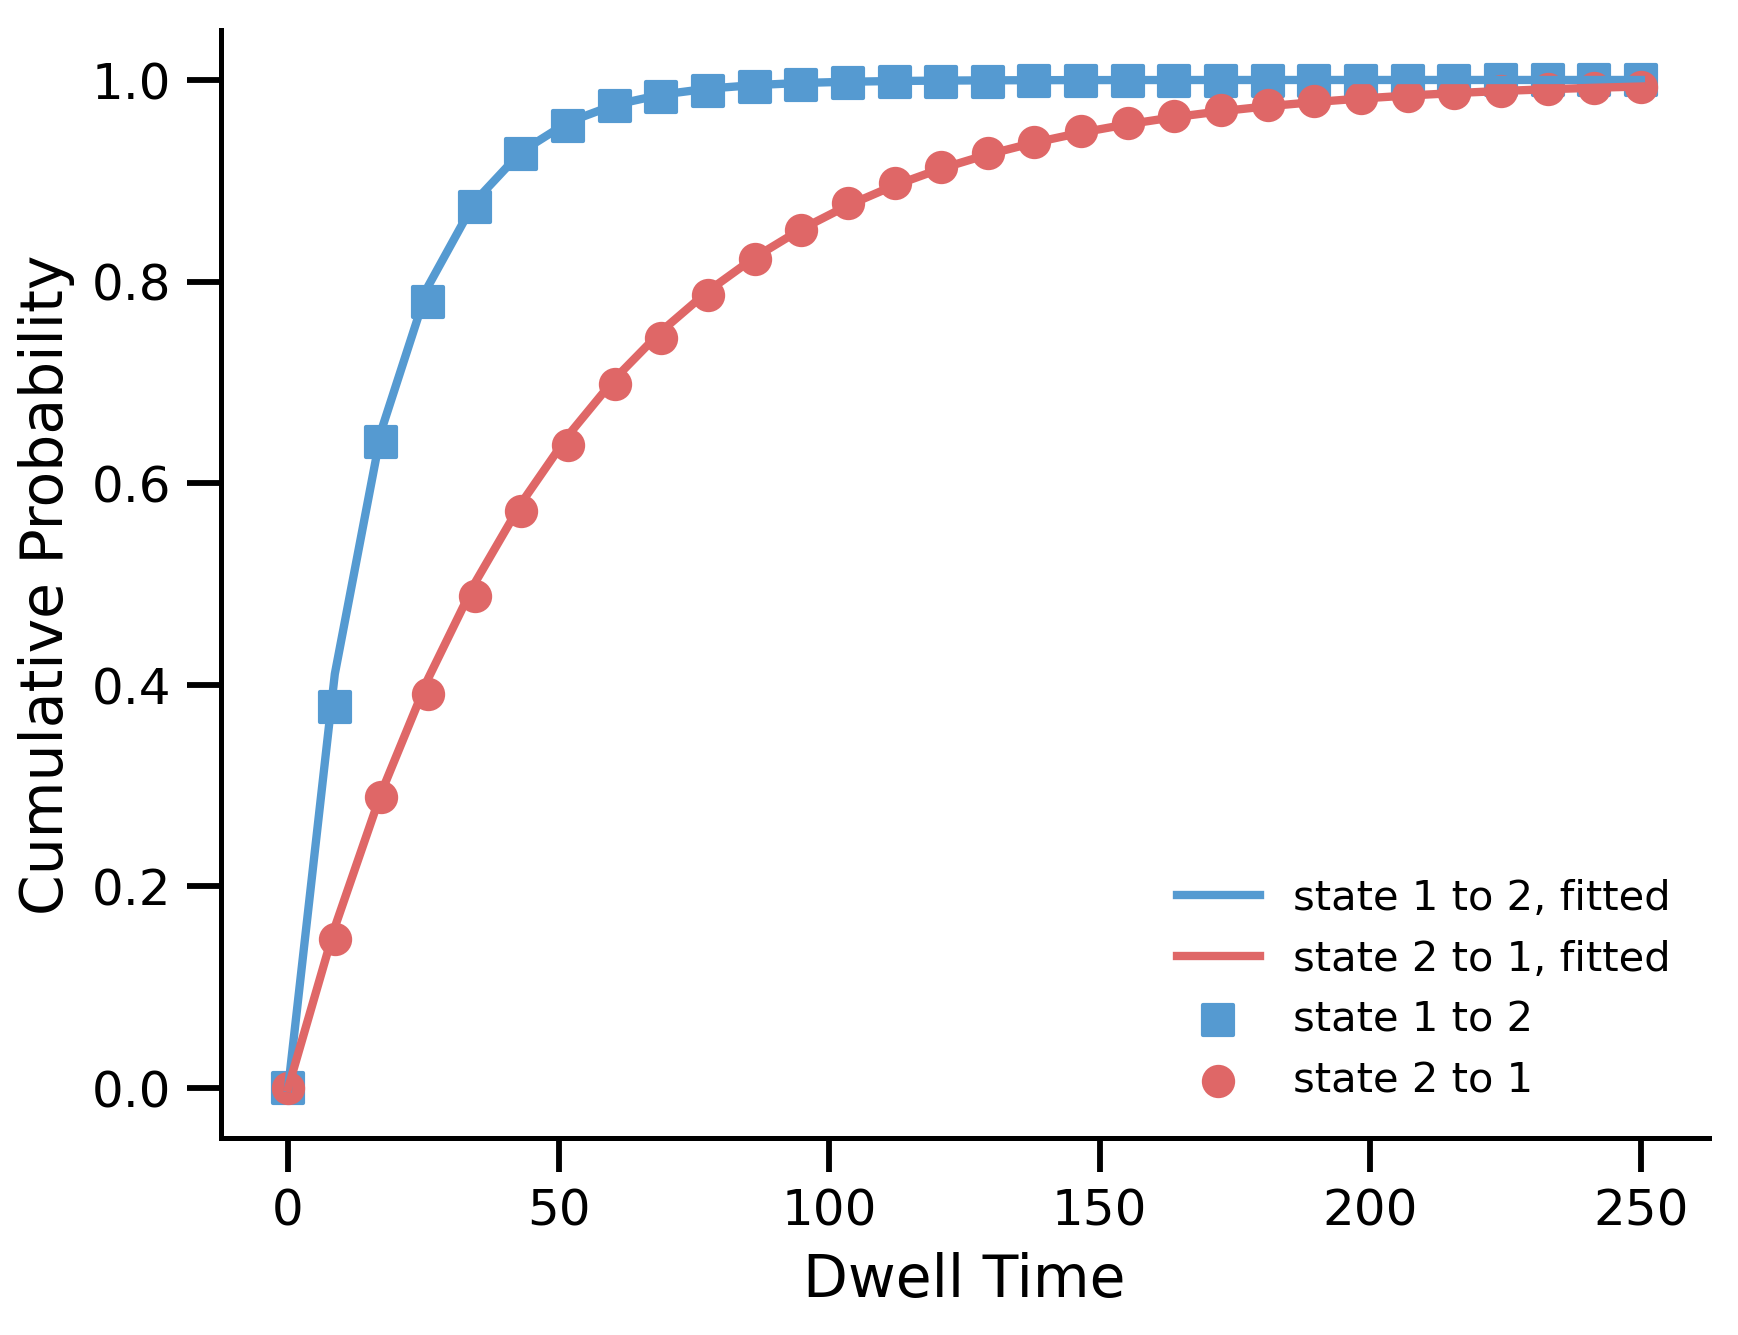

In [256]:
bins = np.linspace(0, 250, 30)
b = 5
with plt.style.context(spstyle.get_style('nature-reviews')):
    # plt.figure(figsize=(8, 6))
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_zero if x > b], bins=bins), color=color[0], marker='s', label='state 1 to 2')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_zero_one * time_resolution * bins), color=color[0], label='state 1 to 2, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_one if x > b], bins=bins), color=color[1], label='state 2 to 1')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_one_zero * time_resolution * bins), color=color[1], label='state 2 to 1, fitted')
    plt.xlabel('Dwell Time')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.savefig('figures/dwell-time-cumulative-prob-fit.svg', transparent=True, dpi=120)